Published on September 04, 2023. By Marília Prata, mpwolke.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dental-xrary-tfrecords/Dental_Xray3.tfrec


In [1]:
#import libraries
import tensorflow as tf
import numpy as np
import IPython.display as display

#Check the raw data from files

We have height and image_raw below. And at the very end width!

But No label or depth.

In [3]:
#https://stackoverflow.com/questions/65007191/how-to-read-decode-tfrecords-file-see-the-images-inside-and-do-augmentation

raw_dataset = tf.data.TFRecordDataset("../input/dental-xrary-tfrecords/Dental_Xray3.tfrec")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "height"
    value {
      int64_list {
        value: 256
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\001\000\000\000\001\000\010\002\000\000\000\323\020?1\000\000 \000IDATx\234\254}I\257,[z\325\336;\"\363\234\223\315in\373\352\225\355\367\\\205]vY\226\014\362\000\t\201\261\204\030\000\003@\030\020 &\214\370\007\374\003\206L\0312\360\014O`\300\300\002[ \333\022\030l\354R\225\213*W\363\372\333\23563O\223\021{o\006\353\256uWD\236{\253l\210\301U\336<\221\021\273\371\232\365\265;\336\334\334\354\355\355m\267\333\313\313\313\333\333\333\333\333\333\256\353b\214!\204RJJ\251i\232\351t\3324M\333\266\323\3514\347|ww\207\377\306\030\233\246Y,\026\223\311d\273\335\336\336\336\336\334\334\244\224r\316\265\326\256\353\272\256K)-\026\213\363\363\363\317>\373\014\367t]\327\367}\316y\261XL\247\323\303\303\303\355v\373\374\371\363RJ\214\261\224RJ\331l6\265\326\315f\363\354\

In [4]:
#Daniel Madmon https://www.kaggle.com/code/danielmadmon/example-for-reading-images-file

#path tf tfrecords file
path = '../input/dental-xrary-tfrecords/Dental_Xray3.tfrec'
raw_image_dataset = tf.data.TFRecordDataset(path)

def _parse_image_function(example_proto):
    image_feature_description = {
        #'label': tf.io.FixedLenFeature([], tf.int64),#We don't have label
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto, image_feature_description)
#map the dataset
parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

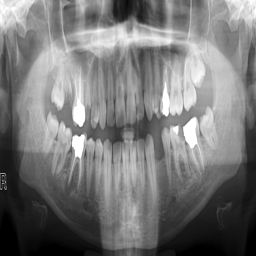

In [5]:
#Daniel Madmon https://www.kaggle.com/code/danielmadmon/example-for-reading-images-file

#read one image, and display, image and label
for image_features in parsed_image_dataset:
      image = image_features['image_raw'].numpy()
      #image_label = image_features['label'].numpy()#We don't have Label
      display.display(display.Image(data=image))
      #print("label: ",image_label)
      break

#Finally, my first tfrec that I could read (decode) .tfrecords file. And see the images inside. 

#I kept Monet, instead of Dental data cause I'm afraid to change anything else.

After 2 days trying to understand tfrec files. I prefered to Kept Monet.
Next time I will change it.

In [15]:
#Clement Delteil https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings

import re
from kaggle_datasets import KaggleDatasets
import glob

GCS_PATH = KaggleDatasets().get_gcs_path('dental-xrary-tfrecords')
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/Dental_Xray3.tfrec'))

#def count_data_items(filenames):
   # n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    #return np.sum(n)

#count_data_items(MONET_FILENAMES)

AttributeError: 'NoneType' object has no attribute 'group'

#AttributeError: 'NoneType' object has no attribute 'group'

In [21]:
#Clement Delteil https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings

# return the image from the TFRecord
image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_raw':      tf.io.FixedLenFeature([], tf.string),
        'height':    tf.io.FixedLenFeature([], dtype=tf.int64),
        'width':     tf.io.FixedLenFeature([], dtype=tf.int64),
       
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image_raw'])
    return image

In [22]:
#Clement Delteil https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings

# define the function to extract the image from the files
def load_data(filenames, labeled=True, ordered=False):
    data = tf.data.TFRecordDataset(filenames)
    data = data.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return data

In [23]:
#Clement Delteil https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings

AUTOTUNE = tf.data.experimental.AUTOTUNE

monet = load_data(MONET_FILENAMES).batch(32)
sample_monet = next(iter(monet))

In [24]:
#Clement Delteil https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings

sample_monet.shape

TensorShape([32, 256, 256, 3])

In [25]:
#Clement Delteil https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings

# define visualization function to view image
def visualize_images(example):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(example[i] * 0.5 + 0.5)
        plt.axis("off")

#Visualizing Dental Panoramics images.

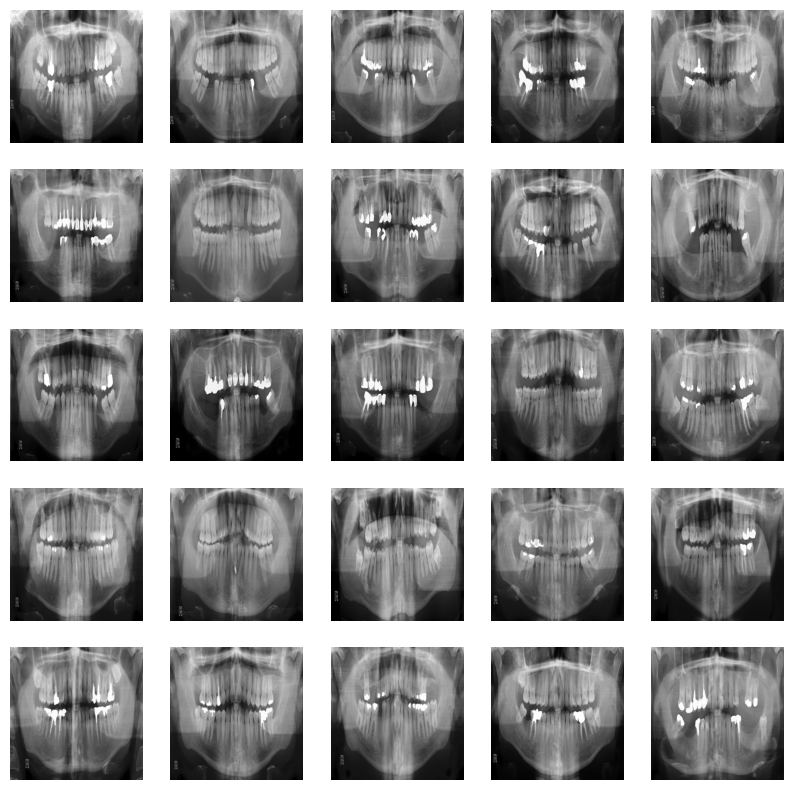

In [26]:
#Clement Delteil https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings

visualize_images(sample_monet)

In [28]:
#Save for the next time
#https://stackoverflow.com/questions/65007191/how-to-read-decode-tfrecords-file-see-the-images-inside-and-do-augmentation

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #Original is 3
import tensorflow as tf, PIL.Image, numpy as np

raw_dataset = tf.data.TFRecordDataset('../input/dental-xrary-tfrecords/Dental_Xray3.tfrec')

for i, raw_record in enumerate(raw_dataset.take(2)):#Original is 3
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    info = {}
    for k, v in example.features.feature.items():
        if k == 'image_raw':
            info[k] = v.bytes_list.value[0]
        elif k in ['height', 'width']:#We don't have depth
            info[k] = v.int64_list.value[0]
    img_arr = np.frombuffer(info['image_raw'], dtype = np.uint8).reshape(
        info['height'], info['width']
    )
    # You can use img_arr numpy array above to directly augment/preprocess
    # your image without saving it to .png.
    img = PIL.Image.fromarray(img_arr)
    img.save(f'Dental_Xray3.tfrec.{str(i).zfill(5)}.png')

ValueError: cannot reshape array of size 54169 into shape (256,256)

#Above,ValueError: cannot reshape array of size 54169 into shape (256,256) 

Besides, we don't have Depth

#No Plot for Dental_Xray3.tfrec

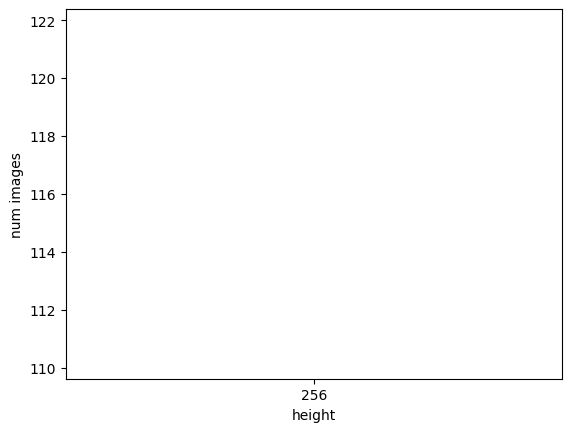

In [29]:
#save for another time since we don't have Labels
#https://stackoverflow.com/questions/65007191/how-to-read-decode-tfrecords-file-see-the-images-inside-and-do-augmentation

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt

raw_dataset = tf.data.TFRecordDataset('../input/dental-xrary-tfrecords/Dental_Xray3.tfrec')

height_cnts = {}
for i, raw_record in enumerate(raw_dataset.as_numpy_iterator()):
    example = tf.train.Example()
    example.ParseFromString(raw_record)
    info = {}
    for k, v in example.features.feature.items():
        if k == 'height':
            info[k] = v.int64_list.value[0]
    height_cnts[info['height']] = height_cnts.get(info['height'], 0) + 1

x, y = zip(*sorted(height_cnts.items(), key = lambda e: e[0]))
plt.xlabel('height')
plt.ylabel('num images')
plt.plot(x, y)
plt.xticks(x)
plt.show()

#Augmentation using gaussian noise and gaussian blur, augmented tfrecord dataset is saved to max_32_set.augmented.tfrecords file:

In [ ]:
#Save for next time since we don't have depth nor labels

#https://stackoverflow.com/questions/65007191/how-to-read-decode-tfrecords-file-see-the-images-inside-and-do-augmentation

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf, tensorflow_addons as tfa, PIL.Image, numpy as np, math

c_inp_fname = 'Dental_Xray3.tfrec'
c_out_fname = 'Dental_Xray3.tfrec'
c_augment_types = ('noise', 'blur', 'noise_blur', 'noise_blur_mirror')
c_res_class_size = None # If None then auto configured to maximal class size

def calc_labels():
    raw_dataset = tf.data.TFRecordDataset(c_inp_fname)
    cnts, labels = {}, []
    for i, raw_record in enumerate(raw_dataset):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        label = example.features.feature['label'].int64_list.value[0]
        cnts[label] = cnts.get(label, 0) + 1
        labels.append(label)
    return cnts, labels

def img_gen():
    raw_dataset = tf.data.TFRecordDataset(c_inp_fname)
    for i, raw_record in enumerate(raw_dataset):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        info = {}
        for k, v in example.features.feature.items():
            if k == 'image_raw':
                info[k] = v.bytes_list.value[0]
            elif k in ['depth', 'height', 'width']:
                info[k] = v.int64_list.value[0]
        img_arr = np.frombuffer(info['image_raw'], dtype = np.uint8).reshape(
            info['height'], info['width'], info['depth']

#Acknowledgements:

Daniel Madmon https://www.kaggle.com/code/danielmadmon/example-for-reading-images-file

Clement Delteil https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings